In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define paths
root_dir = "/Users/ludoviclepic/Downloads/TimeSen2Crop-2"
tile_folder = "32TNT"  # Change if needed
crop_folder = "1"  # Crop type
sample_file_1 = "0.csv"  # First sample
sample_file_2 = "1.csv"  # Second sample
dates_file = "dates.csv"
# Construct file paths
file_path_1 = os.path.join(root_dir, tile_folder, crop_folder, sample_file_1)
file_path_2 = os.path.join(root_dir, tile_folder, crop_folder, sample_file_2)
dates_path = os.path.join(root_dir, tile_folder, dates_file)


In [17]:
df_dates = pd.read_csv(dates_path)
df_dates['acquisition_date'] = pd.to_datetime(df_dates['acquisition_date'], format='%Y%m%d')
print(df_dates.shape)
print(df_dates.loc[0, 'acquisition_date'], df_dates.loc[df_dates.shape[0]-1, 'acquisition_date'])
df_dates.head(4)

(32, 1)
2017-09-04 00:00:00 2018-08-20 00:00:00


,acquisition_date
0,2017-09-04
1,2017-09-24
2,2017-10-04
3,2017-10-14


In [18]:
df1 = pd.read_csv(file_path_1)
print(df1.shape)
df1.head(4)

(32, 10)


,B1,B2,B3,B4,B5,B6,B7,B8,B9,Flag
0,232,623,366,1272,3628,4243,4704,2410,1145,0
1,439,785,573,1624,3832,4387,4859,2809,1330,0
2,1093,1165,1144,1538,2395,2682,3031,1963,1403,0
3,420,879,785,1808,3631,4225,5057,3597,1799,0


In [34]:
import os

root_dir = "/Users/ludoviclepic/Downloads/TimeSen2Crop-2"

# List only the folders (directories) in the root_dir
folders = [name for name in os.listdir(root_dir) 
           if os.path.isdir(os.path.join(root_dir, name))]
print("Folders in", root_dir, ":\n", folders)

Folders in /Users/ludoviclepic/Downloads/TimeSen2Crop-2 :
 ['33TWN', '33UWP', '32TPT', '33UWQ', '33TVM', '33TUM', '33TXN', '33TWM', '32TQT', '33UUP', '33UVP', '33UXP', '2019_33UVP', '33TVN', '32TNT', '33TUN']


33UWP
/Users/ludoviclepic/Downloads/TimeSen2Crop-2/33UWP/dates.csv


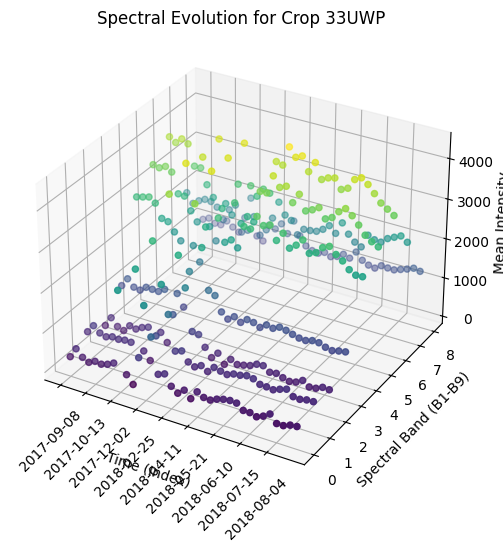

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define paths
root_dir = "/Users/ludoviclepic/Downloads/TimeSen2Crop-2"
folders = [name for name in os.listdir(root_dir) 
           if os.path.isdir(os.path.join(root_dir, name))]

#for folder in folders[1]:
folder = folders[1]

crop_folder = "1"
dates_path = os.path.join(root_dir, folder, "dates.csv")
crop_dir = os.path.join(root_dir, folder, crop_folder)

df_dates = pd.read_csv(dates_path)  
df_dates['acquisition_date'] = pd.to_datetime(df_dates['acquisition_date'], format='%Y%m%d')

# Initialize variables
num_dates = len(df_dates)
num_bands = 9  # From B1 to B9
spectral_sums = np.zeros((num_dates, num_bands))
valid_counts = np.zeros(num_dates)

# Process all CSV files in the crop folder
file_list = [f for f in os.listdir(crop_dir) if f.endswith(".csv")]

for file in file_list:
    file_path = os.path.join(crop_dir, file)
    df = pd.read_csv(file_path, header=0)  # Ensure we read with headers
    # Exclude rows where the flag (last column) is not 0
    valid_rows = df["Flag"] == 0
    spectral_sums[valid_rows] += df.iloc[:, :-1][valid_rows].values  # Ignore Flag column
    valid_counts[valid_rows] += 1

# Compute mean spectral values (avoid division by zero)
mean_spectral = np.divide(spectral_sums, valid_counts[:, np.newaxis], where=valid_counts[:, np.newaxis] > 0)

# 3D Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Create coordinate matrices
time_values = np.arange(num_dates)  # Use indices since dates are not continuous
band_values = np.arange(num_bands)
time_grid, band_grid = np.meshgrid(time_values, band_values, indexing="ij")

# Flatten the matrices for plotting
x_values = time_grid.flatten()
y_values = band_grid.flatten()
z_values = mean_spectral.flatten()

# Scatter plot
ax.scatter(x_values, y_values, z_values, c=z_values, cmap="viridis", marker="o")

# Labels
ax.set_xlabel("Time (Index)")
ax.set_ylabel("Spectral Band (B1-B9)")
ax.set_zlabel("Mean Intensity")
ax.set_title(f"Spectral Evolution for Crop {folder}")

# Adjust X-axis ticks to show actual dates
ax.set_xticks(np.arange(num_dates))
tick_indices = np.arange(0, num_dates, 4)
ax.set_xticks(tick_indices)
ax.set_xticklabels(df_dates["acquisition_date"].dt.strftime("%Y-%m-%d").iloc[tick_indices], rotation=45)
plt.show()


In [18]:
folders[0]

'33TWN'

In [34]:
import os
import pandas as pd
from functools import reduce

root_dir = "/Users/ludoviclepic/Downloads/TimeSen2Crop-2"
folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]

def load_and_prepare(folder):
    csv_path = os.path.join(root_dir, folder, "dates.csv")
    df = pd.read_csv(csv_path)
    df['acquisition_date'] = pd.to_datetime(df['acquisition_date'], format='%Y%m%d')
    return df.rename(columns={'acquisition_date': folder})

# Load all dataframes (excluding the last folder, as in your original code)
dfs = [load_and_prepare(folder) for folder in folders[:-1]]

# Merge all dataframes on the key column using an outer join
merged = reduce(lambda left, right: pd.merge(left, right, left_on=left.columns[0],
                                               right_on=right.columns[0], how='outer'), dfs)

# Reshape the DataFrame and clean the dates
df_long = (merged.melt(id_vars=merged.columns[0], var_name='folder', value_name='date')
           .dropna(subset=['date']))
df_long['date'] = pd.to_datetime(df_long['date'], errors='coerce')
df_long = df_long.dropna(subset=['date']).sort_values(by='date')

Dates = df_long['date'].unique()
Dates

<DatetimeArray>
['2017-09-03 00:00:00', '2017-09-04 00:00:00', '2017-09-05 00:00:00',
 '2017-09-08 00:00:00', '2017-09-10 00:00:00', '2017-09-13 00:00:00',
 '2017-09-15 00:00:00', '2017-09-18 00:00:00', '2017-09-21 00:00:00',
 '2017-09-23 00:00:00',
 ...
 '2019-06-30 00:00:00', '2019-07-05 00:00:00', '2019-07-15 00:00:00',
 '2019-07-20 00:00:00', '2019-07-25 00:00:00', '2019-08-04 00:00:00',
 '2019-08-09 00:00:00', '2019-08-14 00:00:00', '2019-08-19 00:00:00',
 '2019-08-24 00:00:00']
Length: 203, dtype: datetime64[ns]

In [37]:
dates = pd.DataFrame(Dates, columns=['date'])
dates

,date
0,2017-09-03
1,2017-09-04
2,2017-09-05
3,2017-09-08
4,2017-09-10
...,...
198,2019-08-04
199,2019-08-09
200,2019-08-14
201,2019-08-19
